In [1]:
import pandas as pd
import os, sys
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from torch._inductor.utils import get_gpu_dram_gbps

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42

In [2]:
dtype_to_peak_fp = {
    "32": 19.5,
    "tf32": 156,
    "16": 312,
    "b16": 312
}

# Note: hard-coded for A100.
beta = 2.03904

def get_dtype_peak_fp(row):
    if row['dtype_32']:
        return dtype_to_peak_fp["tf32"] # NOTE: for conv2d this is TF32!!
    elif row['dtype_16']:
        return dtype_to_peak_fp["16"]
    elif row['dtype_b16']:
        return dtype_to_peak_fp["b16"]
    else:
        raise ValueError("Unknown dtype in row.")

In [13]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("conv2d", base_dir, sample_rate=0.3)
df = pd.concat([X, y], axis=1)
df.dropna(inplace=True)

34it [00:06,  3.56it/s]

< 0 found in file time.32.1024.0.pkl


44it [00:08,  3.52it/s]

< 0 found in file time.128.512.0.pkl


46it [00:09,  3.37it/s]

< 0 found in file time.128.1024.0.pkl


54it [00:11,  3.97it/s]

< 0 found in file time.512.128.0.pkl


56it [00:12,  3.58it/s]

< 0 found in file time.512.512.0.pkl


58it [00:12,  3.41it/s]

< 0 found in file time.512.1024.0.pkl


59it [00:13,  3.10it/s]

< 0 found in file time.512.1024.1.pkl


64it [00:13,  5.29it/s]

< 0 found in file time.1024.32.0.pkl


66it [00:14,  4.36it/s]

< 0 found in file time.1024.128.0.pkl


68it [00:15,  3.92it/s]

< 0 found in file time.1024.512.0.pkl


70it [00:15,  3.68it/s]

< 0 found in file time.1024.512.1.pkl
< 0 found in file time.1024.1024.0.pkl


72it [00:16,  4.38it/s]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


< 0 found in file time.1024.1024.1.pkl


In [20]:
df = df.query("time > 0")

In [21]:
# Note: gflops_per_ms doesn't account for dtype.
df["gflops_per_ms"] = df["gflops"] / df["time"]
padding = 0
output_padding = 0

# Note: this is a heuristic.
input_memory_accesses = df["b"] * df["in_channels"] * df["iH"] * df["iW"]
kernel_memory_accesses = df["out_channels"] * (df["in_channels"] // df["groups"]) * df["kH"] * df["kW"]
output_memory_accesses = df["b"] * df["out_channels"] * df["oH"] * df["oW"]
df["memory_accesses"] = input_memory_accesses + kernel_memory_accesses + output_memory_accesses


# Intensity := flops / memory accesses
df["intensity"] = (df["gflops"] * 1e9) / df["memory_accesses"]
df["max_gflops_per_ms"] = df.apply(lambda row: get_dtype_peak_fp(row), axis=1)

In [22]:
df["alpha"] = df["gflops_per_ms"] / (beta * df["intensity"])

In [23]:
df.columns

Index(['b', 'in_channels', 'iH', 'iW', 'out_channels', 'groups', 'kH', 'kW',
       'stride', 'dilation', 'oH', 'oW', 'gflops', 'dtype_16', 'dtype_32',
       'dtype_b16', 'transposed_0', 'transposed_1', 'time', 'gflops_per_ms',
       'memory_accesses', 'intensity', 'max_gflops_per_ms', 'alpha'],
      dtype='object')

In [24]:
X, y = (
    df[
        [
            "b",
            "in_channels",
            "iH",
            "iW",
            "out_channels",
            "groups",
            "kH",
            "kW",
            "stride",
            "dilation",
            "oH",
            "oW",
            "gflops",
            "dtype_16",
            "dtype_32",
            "dtype_b16",
            "transposed_0",
            "transposed_1",
            "memory_accesses",
            "intensity",
        ]
    ],
    df[["alpha", "time"]],
)

In [25]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat = False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133214 entries, 42989 to 122402
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   b                133214 non-null  int64  
 1   in_channels      133214 non-null  int64  
 2   iH               133214 non-null  int64  
 3   iW               133214 non-null  int64  
 4   out_channels     133214 non-null  int64  
 5   groups           133214 non-null  int64  
 6   kH               133214 non-null  int64  
 7   kW               133214 non-null  int64  
 8   stride           133214 non-null  int64  
 9   dilation         133214 non-null  int64  
 10  oH               133214 non-null  int64  
 11  oW               133214 non-null  int64  
 12  gflops           133214 non-null  float64
 13  dtype_16         133214 non-null  bool   
 14  dtype_32         133214 non-null  bool   
 15  dtype_b16        133214 non-null  bool   
 16  transposed_0     133214 non-null  bool 

Train--------
Mean Squared Error: 3.400792620971564e-05
MAPE: 0.09520455287203389
R-squared: 0.9665493866873762


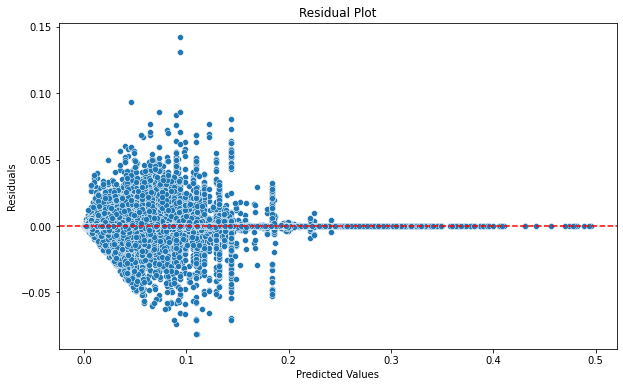

Val--------
Mean Squared Error: 0.0001551542998480419
MAPE: 0.21059836657687664
R-squared: 0.8506547154716169


In [26]:
tree_model = DecisionTreeRegressor(max_depth=20, random_state=random_seed)
tree_model.fit(X_train, y_train["alpha"])

y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train["alpha"], y_hat_train)
plot_residuals(y_train["alpha"], y_hat_train)

print("Val--------")
_ = get_r2_score(y_val["alpha"], y_hat_val)

# plot_residuals(y_val, y_hat_val)

In [27]:
X_val["alpha_hat"] = y_hat_val
X_val["max_gflops_per_ms"] = X_val.apply(lambda row: get_dtype_peak_fp(row), axis=1)

max_time = X_val["gflops"] / X_val["max_gflops_per_ms"]
memory_time = X_val["memory_accesses"] / (X_val["alpha_hat"] * beta * 10**9) 
time_pred = np.maximum(max_time, memory_time)
time_pred = memory_time

Mean Squared Error: 104623.90255994949
MAPE: 0.19229362852540513
R-squared: 0.811941668242813


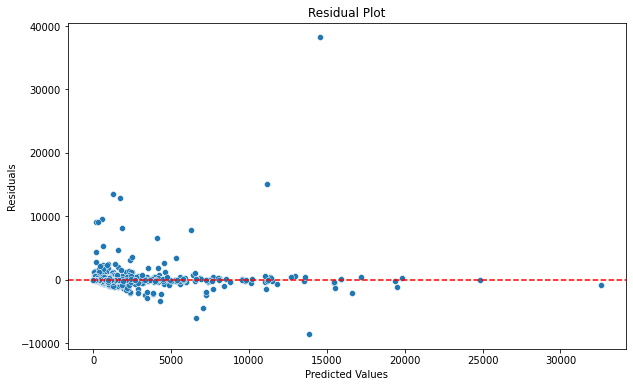

In [28]:
get_r2_score(y_val["time"], time_pred)
plot_residuals(y_val["time"], time_pred)

In [30]:
# predict on the original df.
df["gflops_per_ms_pred"] = tree_model.predict(df[X_train.columns]) * beta * df["intensity"]

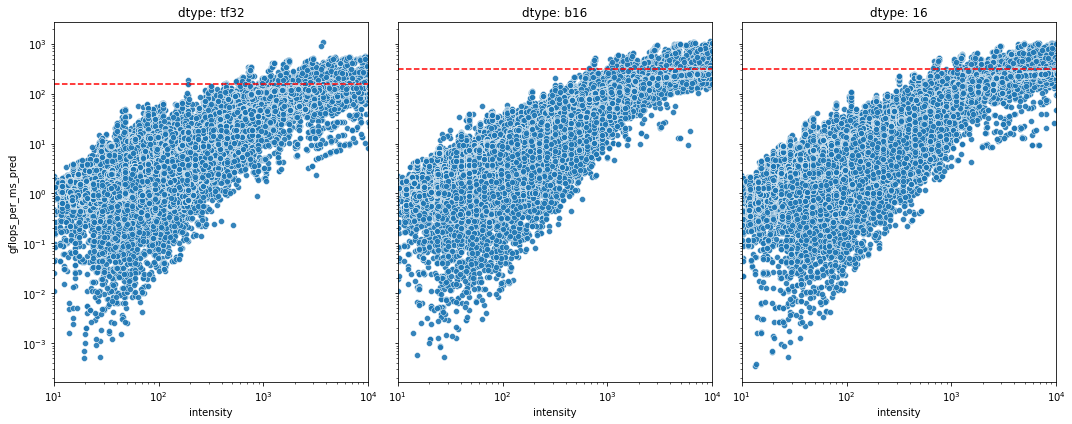

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(["32", "b16", "16"]):
    ax = axes[idx]
    sns.scatterplot(
        x="intensity", y="gflops_per_ms_pred", alpha=0.9, data=df.query(f"dtype_{dtype}"), ax=ax
    )
    if dtype == "32":
        dtype = "tf32"
    ax.set_title(f"dtype: {dtype}")
    ax.axhline(y=dtype_to_peak_fp[dtype], color="r", linestyle="--")

ax.set_xlim(left = 10, right = 10**4)
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()